In [5]:
import os

In [6]:
TITANIC_PATH = os.path.join('datasets', 'titanic')

In [15]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    df = pd.read_csv(csv_path)
    return df

In [20]:
train_data = load_titanic_data('train.csv', TITANIC_PATH)
test_data = load_titanic_data('test.csv', TITANIC_PATH)

In [21]:
train_data.shape

(891, 12)

In [22]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [24]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [25]:
train_data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

In [40]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

imputer = Imputer(strategy='median')

num_pipeline = Pipeline([
        ('select numeric', DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ('imputer', Imputer())])

In [41]:
num_pipeline.fit_transform(train_data)

array([[ 22.        ,   1.        ,   0.        ,   7.25      ],
       [ 38.        ,   1.        ,   0.        ,  71.2833    ],
       [ 26.        ,   0.        ,   0.        ,   7.925     ],
       ..., 
       [ 29.69911765,   1.        ,   2.        ,  23.45      ],
       [ 26.        ,   0.        ,   0.        ,  30.        ],
       [ 32.        ,   0.        ,   0.        ,   7.75      ]])

In [65]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
        
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [66]:
from future_encoders import OneHotEncoder

cat_pipeline = Pipeline([
        ('cat_selector', DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ('imputer', MostFrequentImputer()),
        ('cat_encoder', OneHotEncoder(sparse=False))
    ])

In [67]:
cat_pipeline.fit_transform(train_data)

array([[ 0.,  0.,  1., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  1.,  0.]])

In [68]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [69]:
X_train = preprocess_pipeline.fit_transform(train_data)
y_train = train_data.Survived

In [70]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [71]:
X_test = preprocess_pipeline.fit_transform(test_data)

y_pred = svm_clf.predict(X_test)

In [72]:
from sklearn.cross_validation import cross_val_score

In [73]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.73541397117239815

In [74]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.79919617523550102

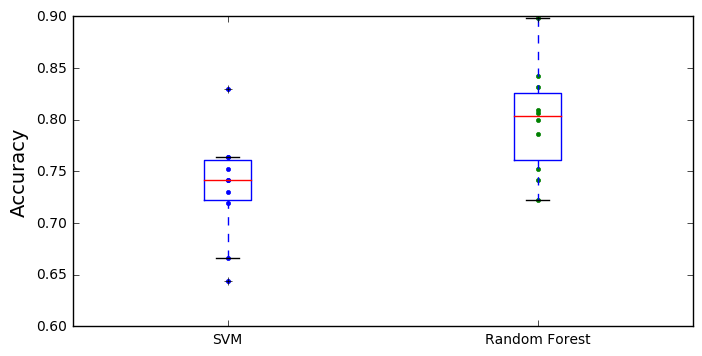

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [95]:
forest_clf.fit(X_train, y_train)
y_pred_forest = forest_clf.predict(X_test)

In [122]:
res = pd.DataFrame({'PassengerID':test_data.PassengerId, 'Survived':y_pred_forest})

In [123]:
res.to_csv(os.path.join(TITANIC_PATH,'results.csv'), index=False)